# TraffiCS

## Data Loading

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandarDate et heure de comptagecaler,RobustScaler,MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import LabelEncoder
import copy

In [11]:
champs_elysees=pd.read_csv('./datasets/Av_Champs_Elysees.csv',sep=';')
convention=pd.read_csv('./datasets/Convention.csv',sep=';')
sts=pd.read_csv('./datasets/Sts_Peres.csv',sep=';')


champs_elysees['Date et heure de comptage'] = pd.to_datetime(champs_elysees['Date et heure de comptage'],utc=True)
convention['Date et heure de comptage'] = pd.to_datetime(convention['Date et heure de comptage'],utc=True)
sts['Date et heure de comptage'] = pd.to_datetime(sts['Date et heure de comptage'],utc=True)

champs_elysees=champs_elysees.sort_values(by='Date et heure de comptage')
convention=convention.sort_values(by='Date et heure de comptage')
sts=sts.sort_values(by='Date et heure de comptage')

convention=convention[(convention['Libelle noeud amont']=='Convention-Blomet')&(convention['Libelle noeud aval']=='Lecourbe-Convention')]
sts=sts[(sts['Libelle noeud amont']=='Sts_Peres-Voltaire')&(sts['Libelle noeud aval']=='Sts_Peres-Universite')]

vacances_df=pd.read_csv('./datasets/holidays.csv')[['date','vacances_zone_c','nom_vacances']]
vacances_df=pd.DataFrame(vacances_df)

## Data Preprocessing

In [12]:
def preprocessing(data,vacances_df):
    df=copy.deepcopy(data)
    df.dropna(inplace=True)
    df=df[["Date et heure de comptage","Taux d'occupation","Débit horaire",'Etat trafic']]
    encoder=LabelEncoder()
    df['Etat trafic']=encoder.fit_transform(df['Etat trafic'])
    df['Date et heure de comptage']=pd.to_datetime(df['Date et heure de comptage'])
    df['hour']=df['Date et heure de comptage'].dt.hour
    df['hour']=df['Date et heure de comptage'].dt.hour
    df['month']=df['Date et heure de comptage'].dt.month

    df['day_of_week'] = df['Date et heure de comptage'].dt.day_name()
    df['week'] = df['Date et heure de comptage'].dt.isocalendar().week
    df['is_weekend'] = (df['day_of_week'].isin(['Saturday', 'Sunday'])).astype(int)
    df.set_index('Date et heure de comptage',inplace=True)

    # Vacances scolaires et jours feriés
    vacances_df['date'] = pd.to_datetime(vacances_df['date'],format='%Y/%m/%d').dt.date
    vacances_df['is_holiday'] =vacances_df.pop('vacances_zone_c').apply(lambda x: 1 if x == True else 0)
    start_date = pd.to_datetime('2022-11-01').date()
    end_date = pd.to_datetime('2023-11-30').date()
    vacances_df = vacances_df[(vacances_df['date'] >= start_date) & (vacances_df['date'] <= end_date)]
    df['date'] = df.index.date
    holiday_mapping = dict(zip(vacances_df['date'], vacances_df['is_holiday']))
    df['is_holiday'] = df['date'].map(holiday_mapping).fillna(0).astype(int)
    df.drop(['date'],axis=1,inplace=True)
    return df

In [13]:
df=preprocessing(champs_elysees,vacances_df)
df

,Taux d'occupation,Débit horaire,Etat trafic,hour,month,day_of_week,week,is_weekend,is_holiday
Date et heure de comptage,,,,,,,,,
2022-11-01 03:00:00+00:00,8.89223,672.0,1,3,11,Tuesday,44,0,1
2022-11-01 04:00:00+00:00,7.12889,513.0,1,4,11,Tuesday,44,0,1
2022-11-01 05:00:00+00:00,6.22500,494.0,1,5,11,Tuesday,44,0,1
2022-11-01 06:00:00+00:00,5.80723,513.0,1,6,11,Tuesday,44,0,1
2022-11-01 07:00:00+00:00,5.57111,484.0,1,7,11,Tuesday,44,0,1
...,...,...,...,...,...,...,...,...,...
2023-11-30 19:00:00+00:00,30.87000,1433.0,3,19,11,Thursday,48,0,0
2023-11-30 20:00:00+00:00,24.38111,1253.0,2,20,11,Thursday,48,0,0
2023-11-30 21:00:00+00:00,20.40723,1069.0,2,21,11,Thursday,48,0,0


## Data Exploration

In [ ]:
df_champs=champs_elysees[["Date et heure de comptage","Taux d'occupation","Débit horaire"]]
df_convention=convention[["Date et heure de comptage","Taux d'occupation","Débit horaire"]]
df_sts=sts[["Date et heure de comptage","Taux d'occupation","Débit horaire"]]


###### Dropping the nan values

df_champs['Date et heure de comptage']=pd.to_datetime(df_champs['Date et heure de comptage'])
df_champs.dropna(inplace=True)

df_convention['Date et heure de comptage']=pd.to_datetime(df_convention['Date et heure de comptage'])
df_convention.dropna(inplace=True)

df_sts['Date et heure de comptage']=pd.to_datetime(df_sts['Date et heure de comptage'])
df_sts.dropna(inplace=True)

In [ ]:
# Some preprocessing before vizualisation...

df_champs["Date et heure de comptage"] = pd.to_datetime(df_champs["Date et heure de comptage"])
df_champs['day_of_week'] = df_champs['Date et heure de comptage'].dt.day_name()
df_champs['week'] = df_champs['Date et heure de comptage'].dt.isocalendar().week

df_convention["Date et heure de comptage"] = pd.to_datetime(df_convention["Date et heure de comptage"])
df_convention['day_of_week'] = df_convention['Date et heure de comptage'].dt.day_name()
df_convention['week'] = df_convention['Date et heure de comptage'].dt.isocalendar().week

df_sts["Date et heure de comptage"] = pd.to_datetime(df_sts["Date et heure de comptage"])
df_sts['day_of_week'] = df_sts['Date et heure de comptage'].dt.day_name()
df_sts['week'] = df_sts['Date et heure de comptage'].dt.isocalendar().week

df_champs.set_index('Date et heure de comptage',inplace=True)
df_convention.set_index('Date et heure de comptage',inplace=True)
df_sts.set_index('Date et heure de comptage',inplace=True)

avg_day_debit_champs={}
avg_day_taux_champs={}
avg_day_debit_convention={}
avg_day_taux_convention={}
avg_day_debit_sts={}
avg_day_taux_sts={}

for day in list(df_champs.day_of_week.unique()):
    avg_day_debit_champs[day]=df_champs[df_champs.day_of_week==day]['Débit horaire'].mean()
    avg_day_taux_champs[day]=df_champs[df_champs.day_of_week==day]["Taux d'occupation"].mean()
    avg_day_debit_convention[day]=df_convention[df_convention.day_of_week==day]['Débit horaire'].mean()
    avg_day_taux_convention[day]=df_convention[df_convention.day_of_week==day]["Taux d'occupation"].mean()
    avg_day_debit_sts[day]=df_sts[df_sts.day_of_week==day]['Débit horaire'].mean()
    avg_day_taux_sts[day]=df_sts[df_sts.day_of_week==day]["Taux d'occupation"].mean()

df_avg_day_debit_champs=pd.DataFrame(list(avg_day_debit_champs.items()),columns=['day_of_week','avg_debit'])
df_avg_day_taux_champs=pd.DataFrame(list(avg_day_taux_champs.items()),columns=['day_of_week','avg_taux'])
df_avg_day_debit_convention=pd.DataFrame(list(avg_day_debit_convention.items()),columns=['day_of_week','avg_debit'])
df_avg_day_taux_convention=pd.DataFrame(list(avg_day_taux_convention.items()),columns=['day_of_week','avg_taux'])
df_avg_day_debit_sts=pd.DataFrame(list(avg_day_debit_sts.items()),columns=['day_of_week','avg_debit'])
df_avg_day_taux_sts=pd.DataFrame(list(avg_day_taux_sts.items()),columns=['day_of_week','avg_taux'])


days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df_avg_day_debit_champs['day_of_week'] = pd.Categorical(df_avg_day_debit_champs['day_of_week'], categories=days_order, ordered=True)
df_avg_day_debit_champs = df_avg_day_debit_champs.sort_values('day_of_week')
df_avg_day_taux_champs['day_of_week'] = pd.Categorical(df_avg_day_taux_champs['day_of_week'], categories=days_order, ordered=True)
df_avg_day_taux_champs = df_avg_day_taux_champs.sort_values('day_of_week')

df_avg_day_debit_convention['day_of_week'] = pd.Categorical(df_avg_day_debit_convention['day_of_week'], categories=days_order, ordered=True)
df_avg_day_debit_convention = df_avg_day_debit_convention.sort_values('day_of_week')
df_avg_day_taux_convention['day_of_week'] = pd.Categorical(df_avg_day_taux_convention['day_of_week'], categories=days_order, ordered=True)
df_avg_day_taux_convention = df_avg_day_taux_convention.sort_values('day_of_week')

df_avg_day_debit_sts['day_of_week'] = pd.Categorical(df_avg_day_debit_sts['day_of_week'], categories=days_order, ordered=True)
df_avg_day_debit_sts = df_avg_day_debit_sts.sort_values('day_of_week')
df_avg_day_taux_sts['day_of_week'] = pd.Categorical(df_avg_day_taux_sts['day_of_week'], categories=days_order, ordered=True)
df_avg_day_taux_sts = df_avg_day_taux_sts.sort_values('day_of_week')






In [ ]:
df_sts['month'] = df_sts.index.month
df_sts['year'] = df_sts.index.year
df_sts['hour'] = df_sts.index.hour

df_champs['month'] = df_champs.index.month
df_champs['year'] = df_champs.index.year
df_champs['hour'] = df_champs.index.hour

df_convention['month'] = df_convention.index.month
df_convention['year'] = df_convention.index.year
df_convention['hour'] = df_convention.index.hour

C:\Users\Ibra\AppData\Local\Temp\ipykernel_91508\3900859298.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, i].set_xticklabels(datasets_debit[i]['day_of_week'], rotation=45, ha='right')  # Rotate x-labels
C:\Users\Ibra\AppData\Local\Temp\ipykernel_91508\3900859298.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, i].set_xticklabels(datasets_debit[i]['day_of_week'], rotation=45, ha='right')  # Rotate x-labels
C:\Users\Ibra\AppData\Local\Temp\ipykernel_91508\3900859298.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, i].set_xticklabels(datasets_debit[i]['day_of_week'], rotation=45, ha='right')  # Rotate x-labels
C:\Users\Ibra\AppData\Local\Temp\ipykernel_91508\3900859298.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, i].set_xticklabels(datasets_taux[i]['day_of_week'], rotation=45, ha='right')  # Rotate x-labels
C:\Users\

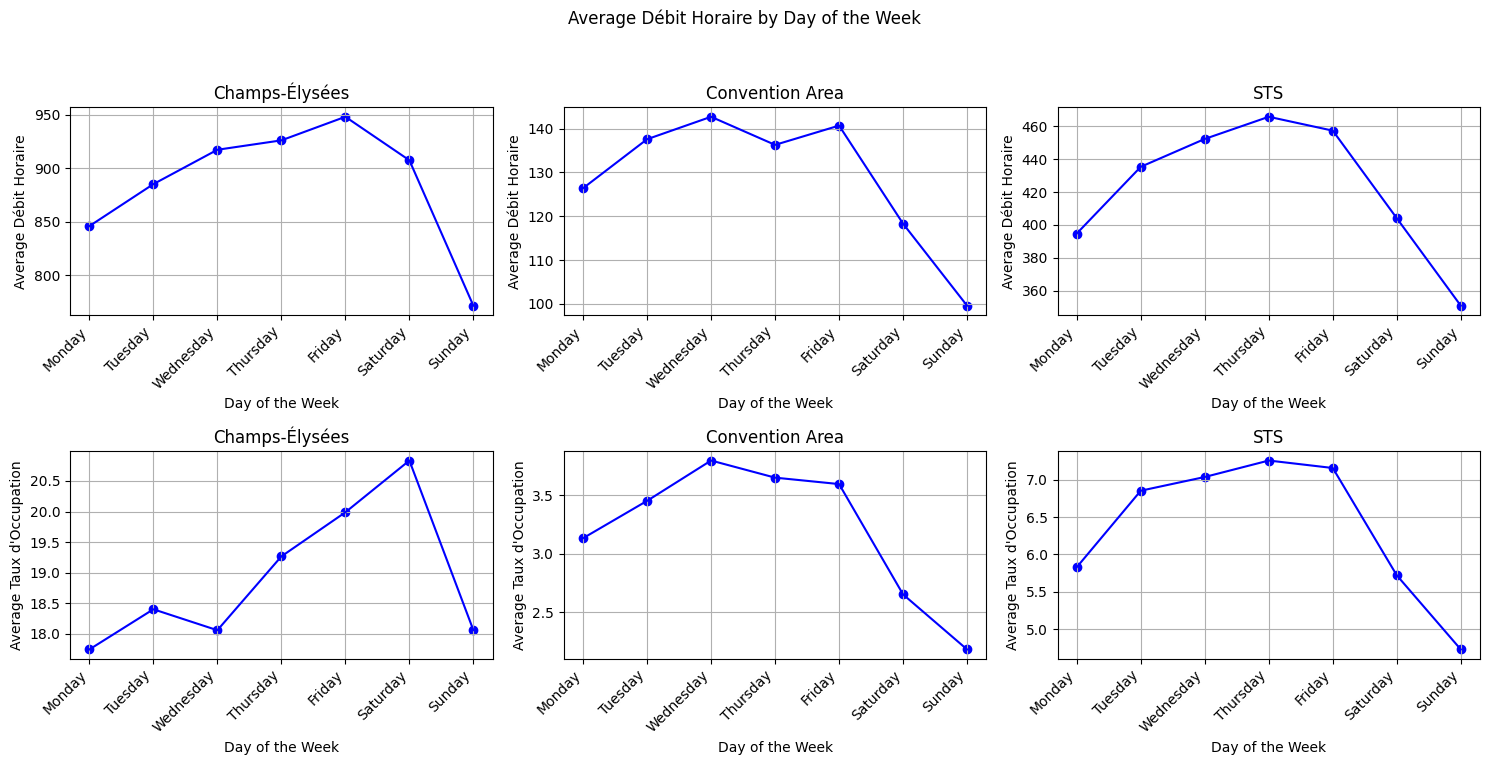

In [19]:
sns.set_palette('Blues')

fig, axs = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Average Débit Horaire by Day of the Week')

datasets_debit = [df_avg_day_debit_champs, df_avg_day_debit_convention, df_avg_day_debit_sts]
titles_debit = ['Champs-Élysées', 'Convention Area', 'STS']

for i in range(3):
    axs[0, i].scatter(datasets_debit[i]['day_of_week'], datasets_debit[i]['avg_debit'], color='blue')
    axs[0, i].plot(datasets_debit[i]['day_of_week'], datasets_debit[i]['avg_debit'], linestyle='-', color='blue')
    axs[0, i].set_title(titles_debit[i])
    axs[0, i].set_xlabel('Day of the Week')
    axs[0, i].set_ylabel('Average Débit Horaire')
    axs[0, i].grid(True)
    axs[0, i].set_xticklabels(datasets_debit[i]['day_of_week'], rotation=45, ha='right')  # Rotate x-labels


datasets_taux = [df_avg_day_taux_champs, df_avg_day_taux_convention, df_avg_day_taux_sts]
titles_taux = ['Champs-Élysées', 'Convention Area', 'STS']

for i in range(3):
    axs[1, i].scatter(datasets_taux[i]['day_of_week'], datasets_taux[i]['avg_taux'], color='blue')
    axs[1, i].plot(datasets_taux[i]['day_of_week'], datasets_taux[i]['avg_taux'], linestyle='-', color='blue')
    axs[1, i].set_title(titles_taux[i])
    axs[1, i].set_xlabel('Day of the Week')
    axs[1, i].set_ylabel('Average Taux d\'Occupation')
    axs[1, i].grid(True)
    axs[1, i].set_xticklabels(datasets_taux[i]['day_of_week'], rotation=45, ha='right')  # Rotate x-labels

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the subplot layout
plt.show()

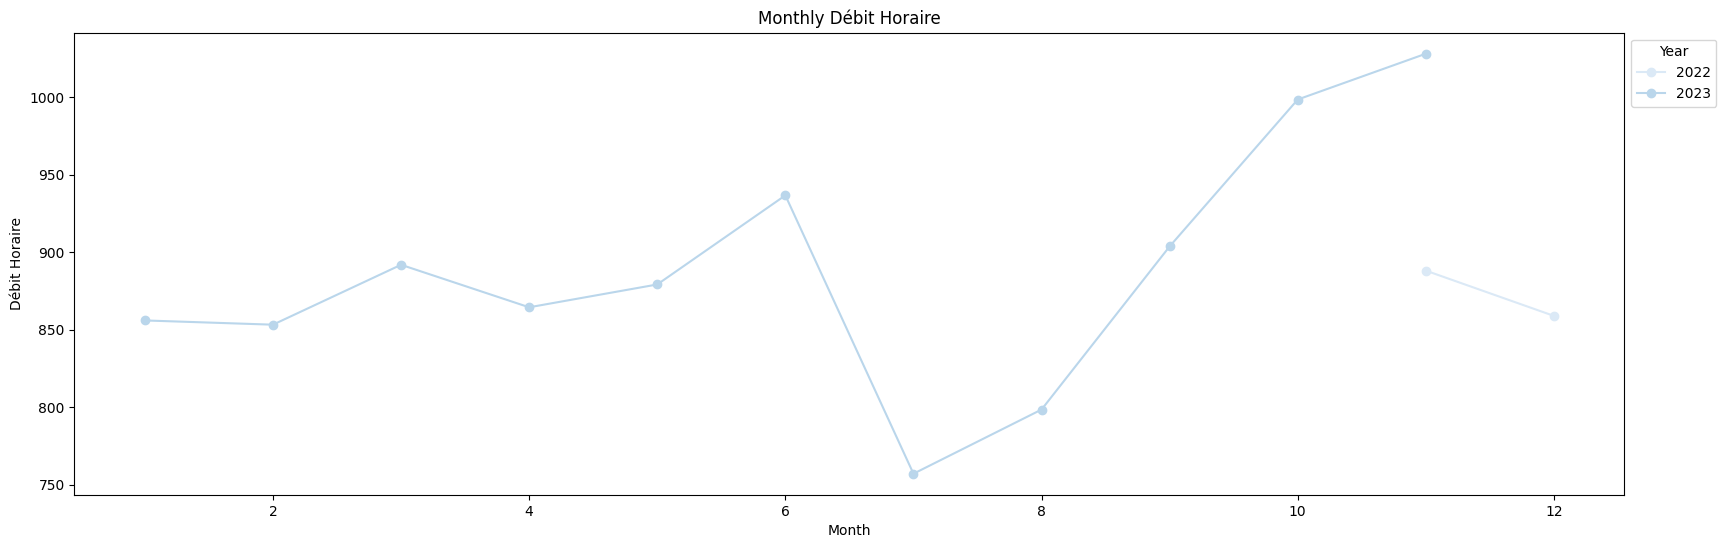

In [22]:
pivot = pd.pivot_table(df_champs, values='Débit horaire', index='month', columns='year', aggfunc='mean')

# Reorder months
months_order = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
pivot = pivot.reindex(months_order)

pivot.plot(figsize=(20, 6), marker='o')
plt.title('Monthly Débit Horaire')
plt.xlabel('Month')
plt.ylabel('Débit Horaire')
plt.legend(title='Year', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()



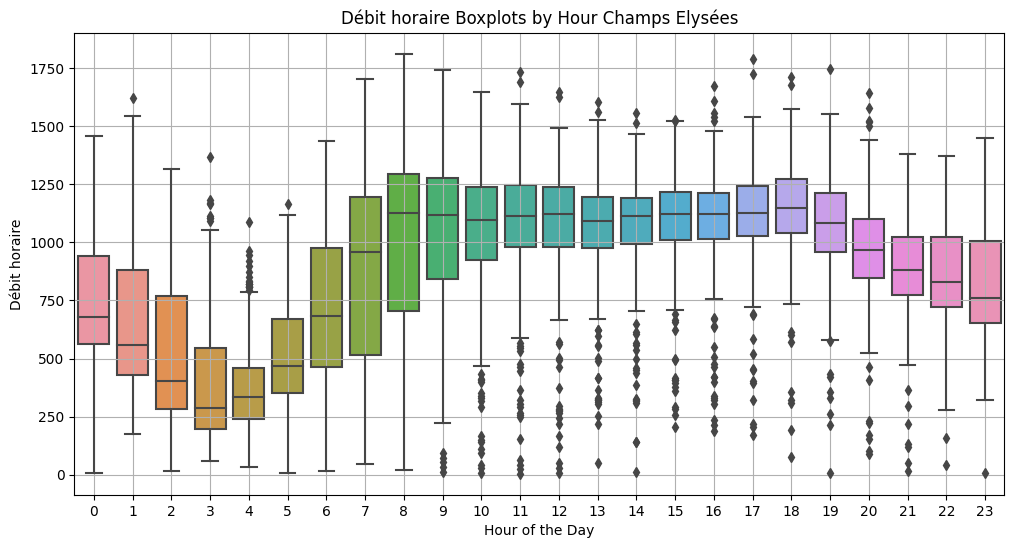

In [23]:
# Plotting boxplots for each hour
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='Débit horaire', data=df_champs)
plt.title('Débit horaire Boxplots by Hour Champs Elysées')
plt.xlabel('Hour of the Day')
plt.ylabel('Débit horaire')
plt.grid(True)
plt.show()

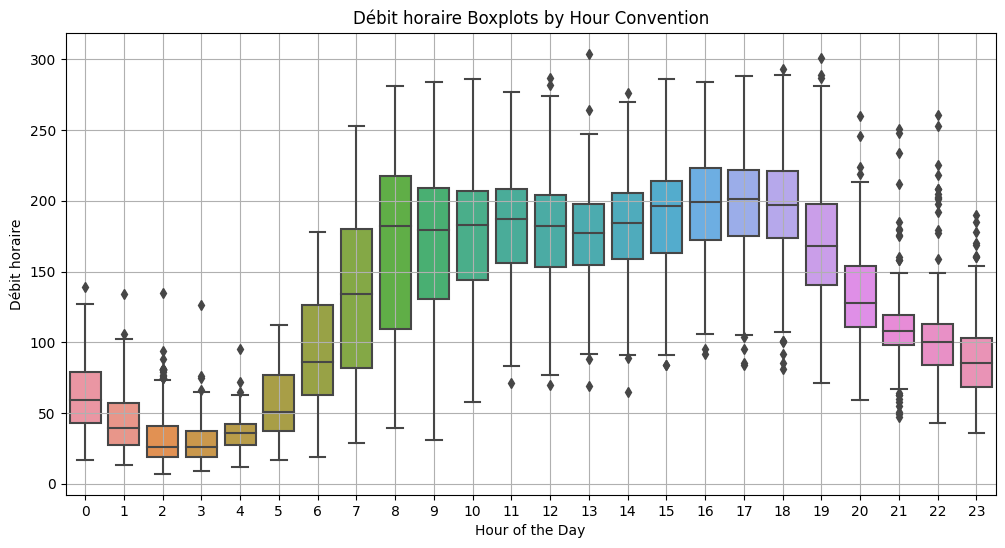

In [24]:
# Plotting boxplots for each hour
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='Débit horaire', data=df_convention)
plt.title('Débit horaire Boxplots by Hour Convention')
plt.xlabel('Hour of the Day')
plt.ylabel('Débit horaire')
plt.grid(True)
plt.show()

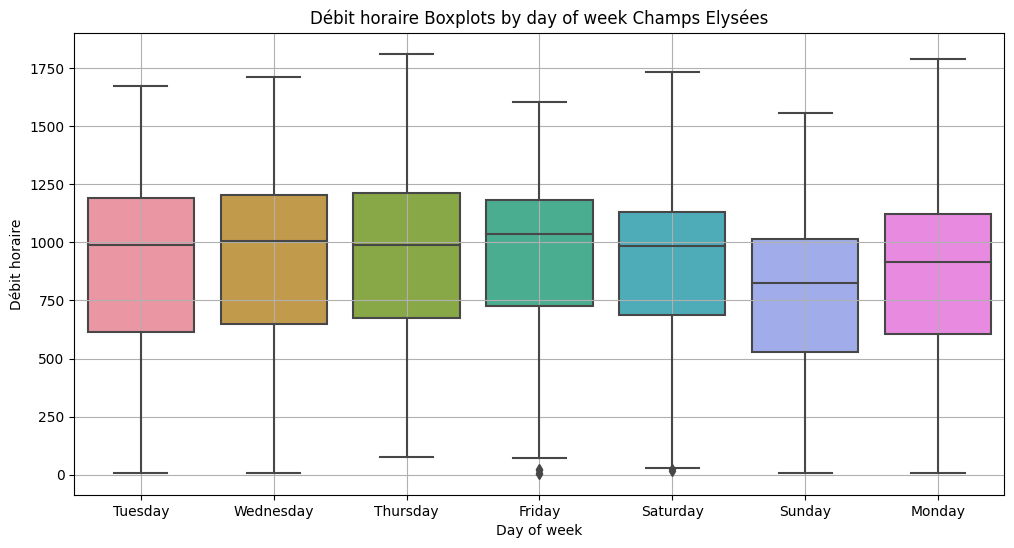

In [25]:
# Plotting boxplots for each hour
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_of_week', y='Débit horaire', data=df_champs)
plt.title('Débit horaire Boxplots by day of week Champs Elysées')
plt.xlabel('Day of week')
plt.ylabel('Débit horaire')
plt.grid(True)
plt.show()

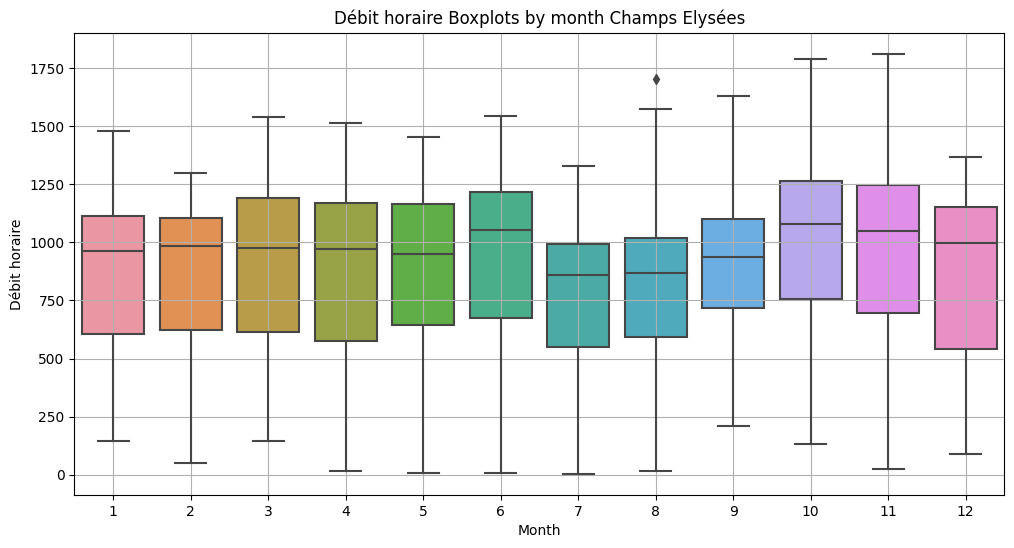

In [26]:
# Plotting boxplots for each hour
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='Débit horaire', data=df_champs)
plt.title('Débit horaire Boxplots by month Champs Elysées')
plt.xlabel('Month')
plt.ylabel('Débit horaire')
plt.grid(True)
plt.show()

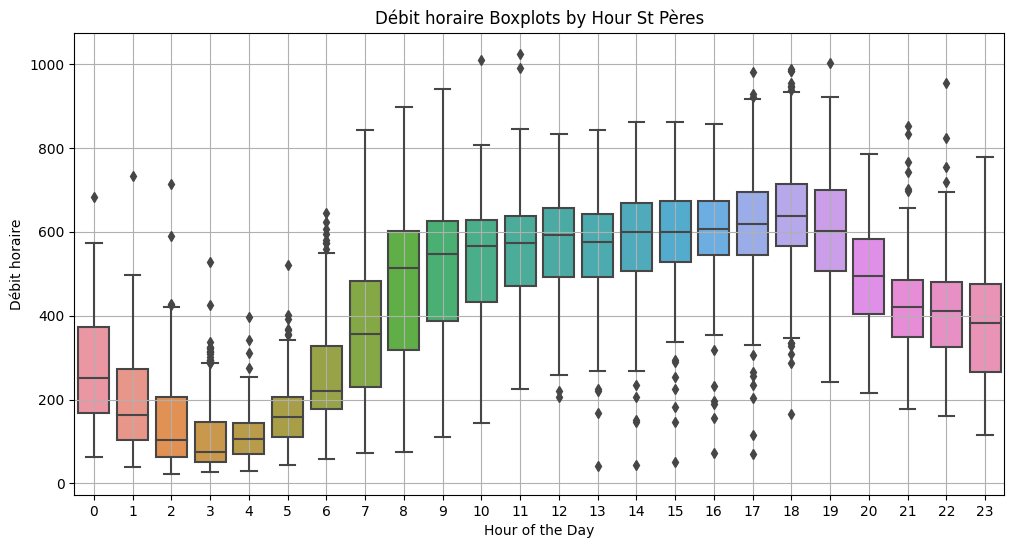

In [27]:
# Plotting boxplots for each hour
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='Débit horaire', data=df_sts)
plt.title('Débit horaire Boxplots by Hour St Pères')
plt.xlabel('Hour of the Day')
plt.ylabel('Débit horaire')
plt.grid(True)
plt.show()

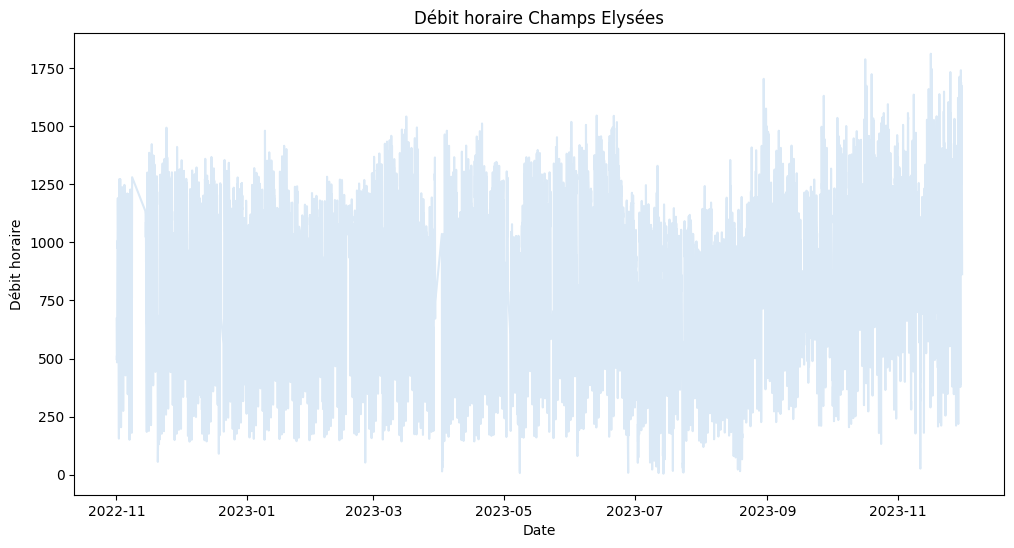

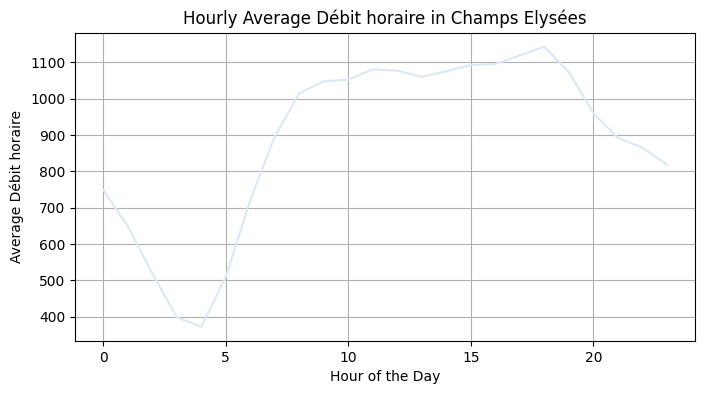

In [35]:
# Time Series Plot
plt.figure(figsize=(12, 6))
plt.plot(df_champs['Débit horaire'])
plt.title('Débit horaire Champs Elysées')
plt.xlabel('Date')
plt.ylabel('Débit horaire')
plt.show()

# Hourly Average Plot
hourly_avg = df_champs.groupby(df_champs.index.hour)['Débit horaire'].mean()
plt.figure(figsize=(8, 4))
plt.plot(hourly_avg)
plt.title('Hourly Average Débit horaire in Champs Elysées')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Débit horaire')
plt.grid(True)

plt.show()

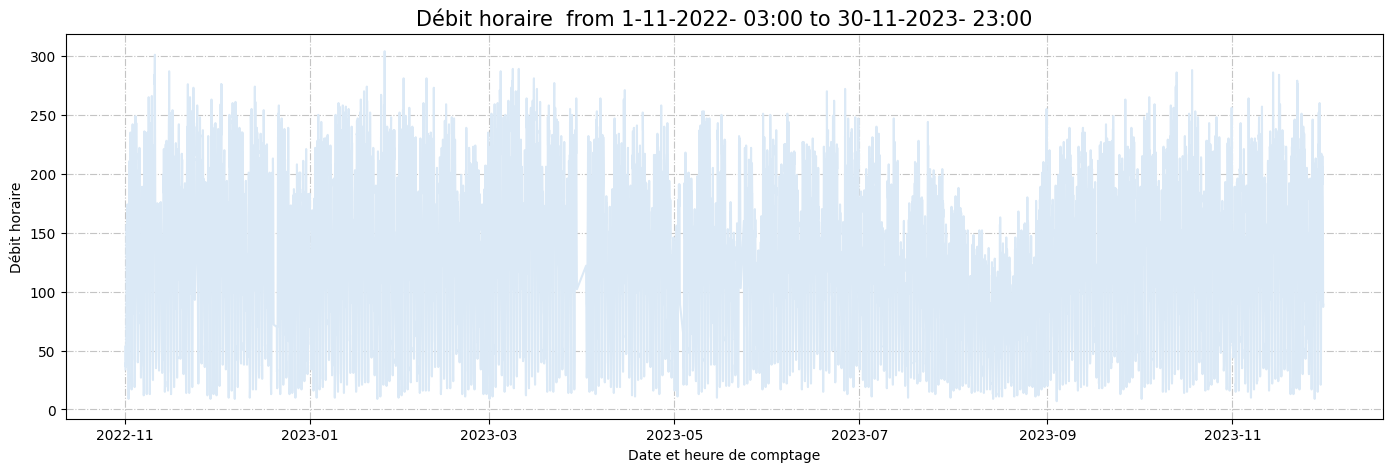

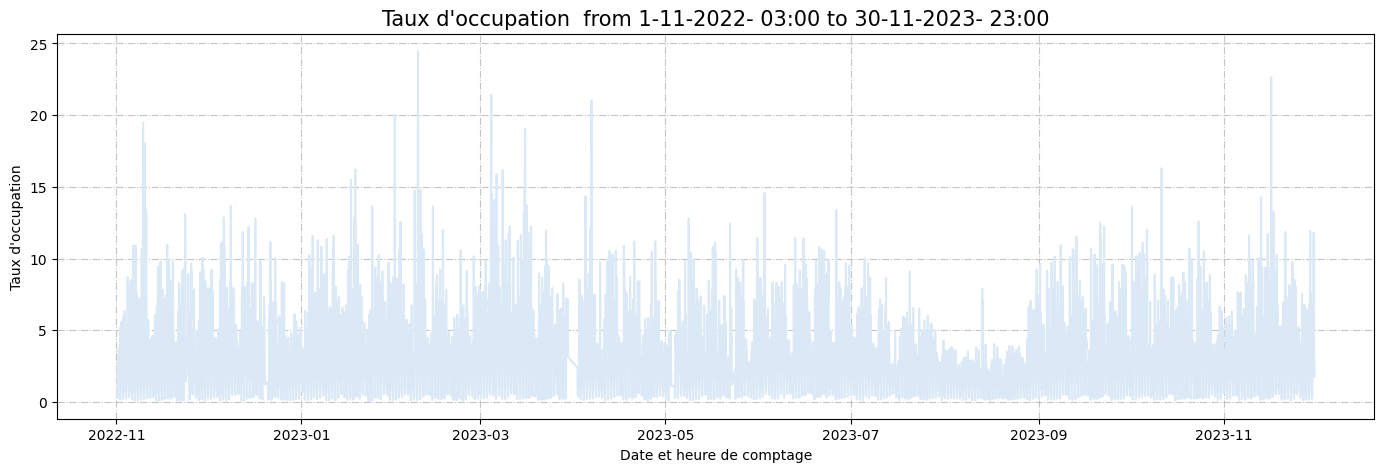

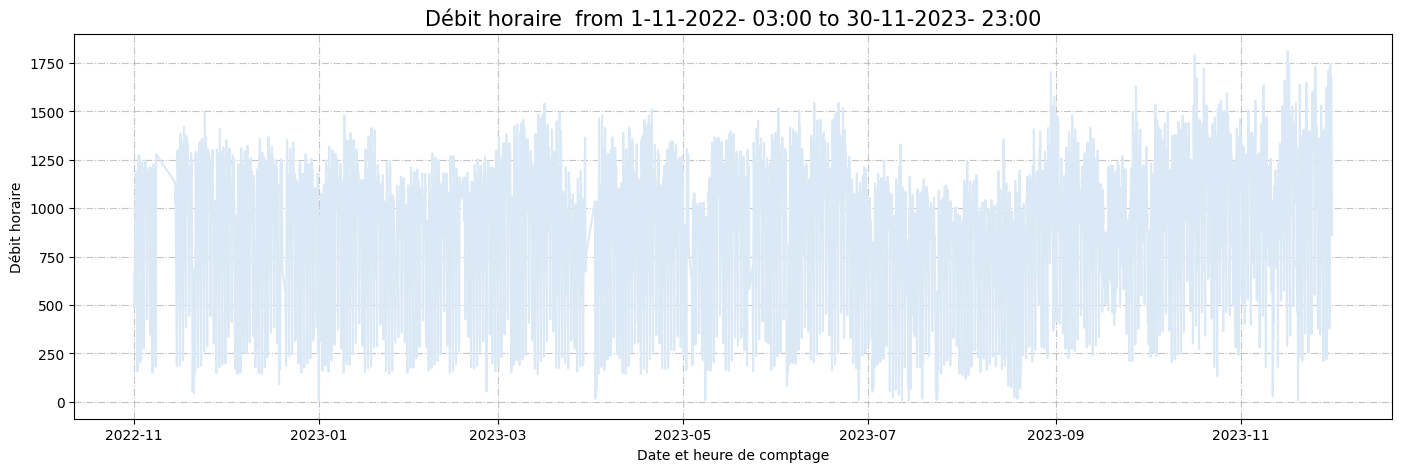

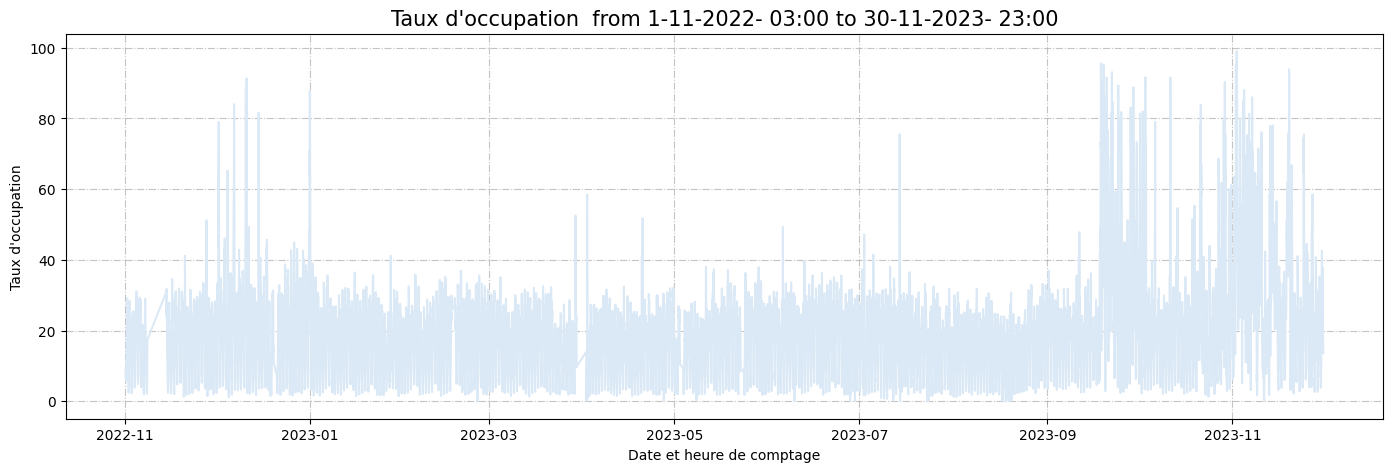

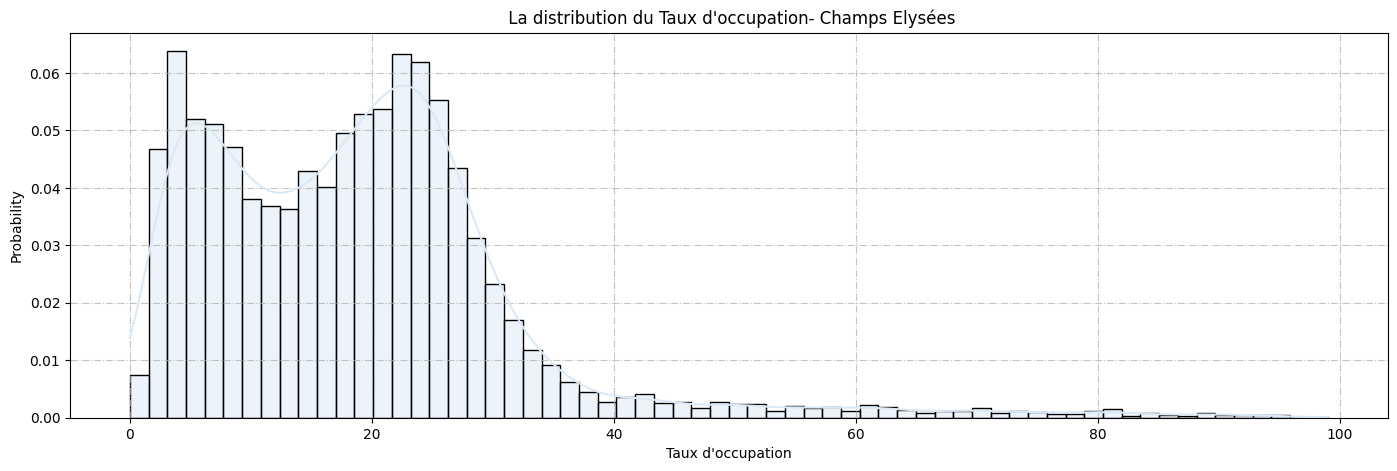

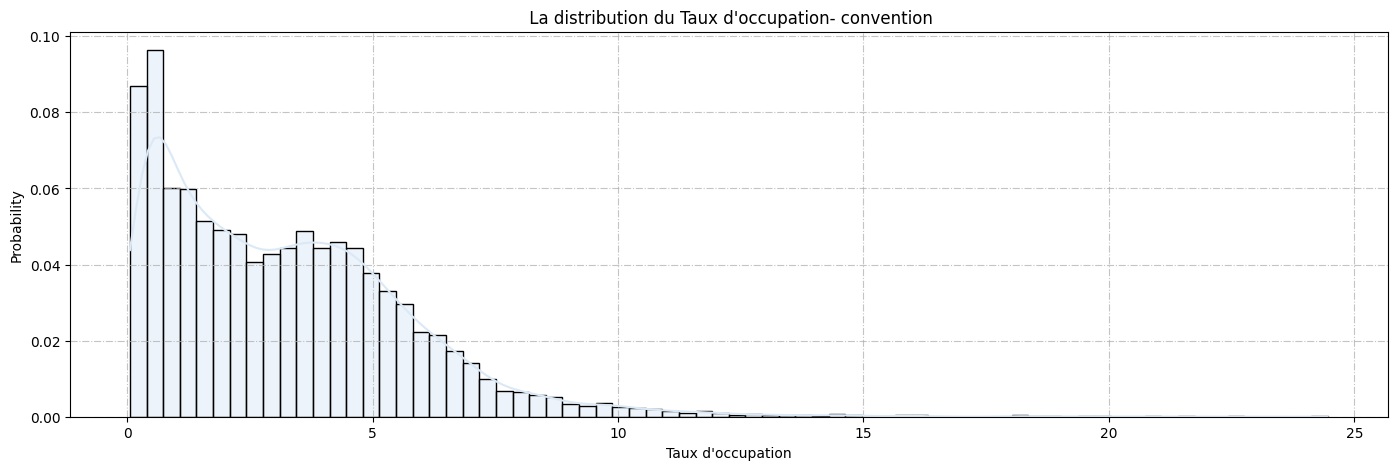

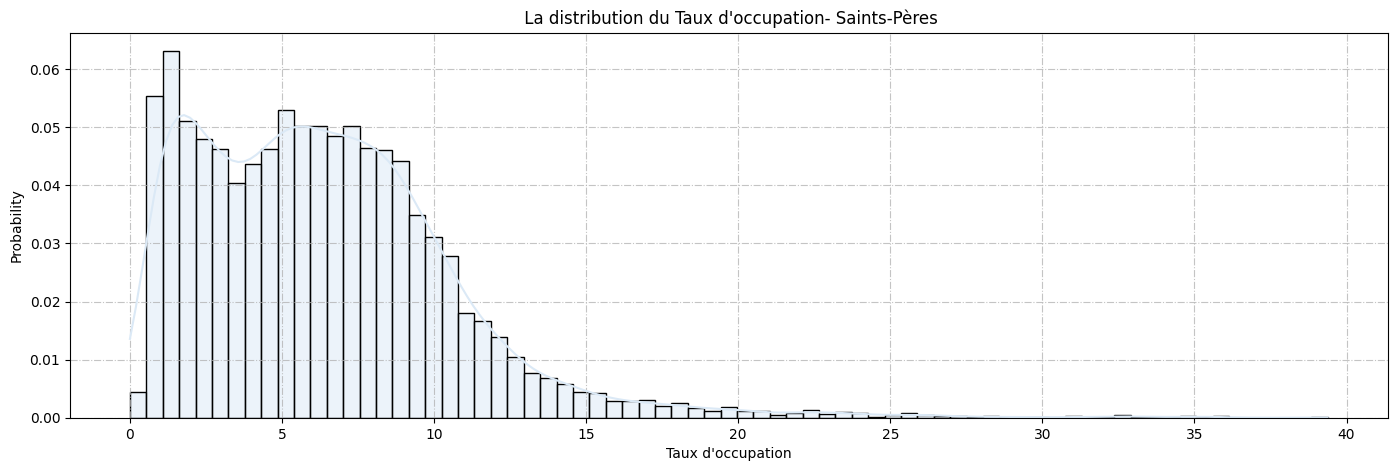

In [38]:
def make_time_series_plot(data,var):
    f, ax = plt.subplots(figsize=(17, 5))
    ax = sns.lineplot(data=data, y=var, x='Date et heure de comptage', ax=ax)
    start = data.head(1)['Date et heure de comptage']
    end = data.tail(1)['Date et heure de comptage']
    ax.set_title(f'{var}  from {start.dt.day.iloc[0]}-{start.dt.month.iloc[0]}-{start.dt.year.iloc[0]}- 03:00 to {end.dt.day.iloc[0]}-{end.dt.month.iloc[0]}-{end.dt.year.iloc[0]}- 23:00', fontsize=15)
    ax.grid(True, ls='-.', alpha=0.75)
    plt.show()

make_time_series_plot(convention,'Débit horaire')
make_time_series_plot(convention,"Taux d'occupation")
make_time_series_plot(champs_elysees,'Débit horaire')
make_time_series_plot(champs_elysees,"Taux d'occupation")

f, ax = plt.subplots(figsize=(17, 5))
ax = sns.histplot(champs_elysees["Taux d'occupation"], kde=True, stat='probability')
ax.set_title(" La distribution du Taux d'occupation- Champs Elysées")
ax.grid(True, ls='-.', alpha=0.75)
plt.show()

f, ax = plt.subplots(figsize=(17, 5))
ax = sns.histplot(convention["Taux d'occupation"], kde=True, stat='probability')
ax.set_title(" La distribution du Taux d'occupation- convention")
ax.grid(True, ls='-.', alpha=0.75)
plt.show()

f, ax = plt.subplots(figsize=(17, 5))
ax = sns.histplot(sts["Taux d'occupation"], kde=True, stat='probability')
ax.set_title(" La distribution du Taux d'occupation- Saints-Pères")
ax.grid(True, ls='-.', alpha=0.75)
plt.show()




## Outliers detection and cleaning

In [32]:
#quartile detection of outliers

list_outliers=[] 
for hour in range(24):
    hour_data = df[df['hour'] == hour]['Débit horaire']

    q1 = np.percentile(hour_data, 25)
    q3 = np.percentile(hour_data, 75)
    iqr = q3 - q1

    #  whiskers
    lower_whisker = q1 - 1.5 * iqr
    upper_whisker = q3 + 1.5 * iqr

    # Identify outliers
    outliers = list(hour_data[(hour_data < lower_whisker) | (hour_data > upper_whisker)].index)
    list_outliers+=outliers

In [34]:
df_no_outliers=df.drop(list_outliers)
df_no_outliers

,Taux d'occupation,Débit horaire,Etat trafic,hour,month,day_of_week,week,is_weekend,is_holiday
Date et heure de comptage,,,,,,,,,
2022-11-01 03:00:00+00:00,8.89223,672.0,1,3,11,Tuesday,44,0,1
2022-11-01 04:00:00+00:00,7.12889,513.0,1,4,11,Tuesday,44,0,1
2022-11-01 05:00:00+00:00,6.22500,494.0,1,5,11,Tuesday,44,0,1
2022-11-01 06:00:00+00:00,5.80723,513.0,1,6,11,Tuesday,44,0,1
2022-11-01 07:00:00+00:00,5.57111,484.0,1,7,11,Tuesday,44,0,1
...,...,...,...,...,...,...,...,...,...
2023-11-30 19:00:00+00:00,30.87000,1433.0,3,19,11,Thursday,48,0,0
2023-11-30 20:00:00+00:00,24.38111,1253.0,2,20,11,Thursday,48,0,0
2023-11-30 21:00:00+00:00,20.40723,1069.0,2,21,11,Thursday,48,0,0


## Our Model : PROPHET

In [40]:
from prophet import Prophet

df_prophet = df_no_outliers
# Get the date 7 days before the last date in the dataset
cutoff_date = df_prophet['Date et heure de comptage'].max() - pd.Timedelta(days=7)


# Split the data
train = df_prophet[df_prophet['Date et heure de comptage'] <= cutoff_date]
test = df_prophet[df_prophet['Date et heure de comptage'] > cutoff_date]
# Initialize the Prophet model
model = Prophet()
model.fit(train)
future = model.make_future_dataframe(periods=10, freq='D')
forecast = model.predict(future)
# Extract the predicted values for the test set dates
predicted = forecast[forecast['Date et heure de comptage'].isin(test['Date et heure de comptage'])]
# Merge the predictions with the test set
test = test.set_index('Date et heure de comptage')
predicted = predicted.set_index('Date et heure de comptage')
comparison_df = test.join(predicted[['yhat']], how='inner')
from sklearn.metrics import mean_squared_error

# Calculate MSE
mse = mean_squared_error(comparison_df['y'], comparison_df['yhat'])
print(f'Mean Squared Error for taux: {mse}')

Importing plotly failed. Interactive plots will not work.


KeyError: 'Date et heure de comptage'